In [1]:
import pandas as pd
import math
from pandas.io import gbq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
%matplotlib inline

## Importing and Processing the Data

In [2]:
os.chdir("../data")

In [3]:
df_g = pd.read_csv('G_raw.csv')
df_g['topic']='G' #Adding a topic column to backout the context of the tweet in the future
df_m = pd.read_csv('M_raw.csv')
df_m['topic']='M'
df_c = pd.read_csv('C_raw.csv')
df_c['topic']='C'

In [4]:
df_g.loc()[1]

id_str                                                    661664563377676288
timestamp                                                2015-11-03 22:01:39
retweeted_status.id_str                                                  NaN
user.id_str                                                         38122727
user.screen_name                                                ROCKWITHBECK
user.location                                               Atlanta, Georgia
user.description           War Veteran who loves his country. Never forge...
text                       BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO AL...
user.followers_count                                                   20664
user.verified                                                          False
contains.url                                                            True
contains.media                                                         False
ideology                                                            0.895322

## Cleaning Merged Dataframe

In [5]:
df=df_g.append(df_m).append(df_c) #Merging the three topic dataframes

In [6]:
bins = [-5, -.7, -.1, .1, .7, 5] #Defining ideology bins for users
bin_names = ['strong_liberal', 'slight_liberal', 'non_partisan', 'slight_conservative', 'strong_conservative']
df['ideo_bin'] = pd.cut(df['ideology'], bins, labels=bin_names)

In [7]:
df['retweeted_status.id_str']=df['retweeted_status.id_str'].map(lambda x: '{:.0f}'.format(x))
df['retweeted_status.id_str']=df['retweeted_status.id_str'].astype(str) #Formatting the retweet id field
df['id_str']=df['id_str'].map(lambda x: '{:.0f}'.format(x))
df['id_str']=df['id_str'].astype(str) #Formatting the tweet id field

In [8]:
df_retweets=df[['ideo_bin','retweeted_status.id_str']].groupby(['retweeted_status.id_str','ideo_bin']).size().reset_index()
#Creating a retweets dataset to count retweets (engagement) by ideology bin of retweeter

In [9]:
df=df[df['retweeted_status.id_str'] == 'nan'] #removing retweets from the dataset

In [10]:
df=df.reset_index(drop=True)

In [11]:
df=df[df['text'].str.match('RT @')==False] #removing retweets from the dataset that were not correctly labeled

In [12]:
df_retweets.columns = ['tweet_id', 'ideo_bin', 'retweets']

In [13]:
df_retweets=df_retweets.pivot(index='tweet_id', columns='ideo_bin', values='retweets').fillna(0)

In [14]:
df_w_rt = pd.merge(left=df, right=df_retweets, how='left', left_on='id_str', right_index=True)

In [15]:
df_w_rt.update(df_w_rt[['strong_liberal', 'slight_liberal', 'non_partisan', 'slight_conservative', 'strong_conservative']].fillna(0))
df_w_rt.rename(columns={'strong_liberal': 'strong_liberal_rts', 'slight_liberal': 'slight_liberal_rts', 'non_partisan': 'non_partisan_rts', 'slight_conservative': 'slight_conservative_rts', 'strong_conservative': 'strong_conservative_rts'}, inplace=True)

In [16]:
df_w_rt['retweets']=df_w_rt['strong_liberal_rts']+df_w_rt['slight_liberal_rts']+df_w_rt['non_partisan_rts']+df_w_rt['slight_conservative_rts']+df_w_rt['strong_conservative_rts']

In [17]:
del df_w_rt['retweeted_status.id_str']

## Merged Dataframe Visualizations

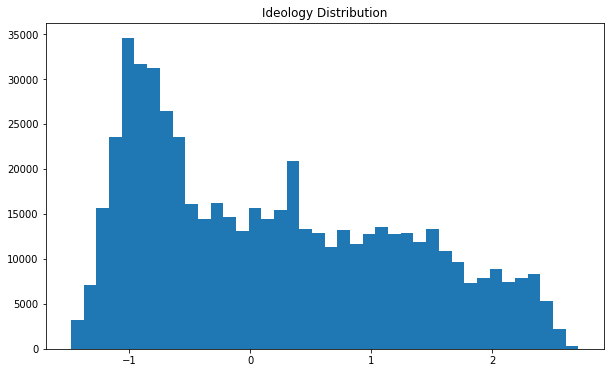

In [18]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt['ideology'], bins=40)
plt.title('Ideology Distribution')

In [19]:
df_w_rt['log_followers']=np.log(df_w_rt['user.followers_count'])

/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [20]:
df_w_rt['log_followers']=df_w_rt['log_followers'].replace(-np.inf, 0)

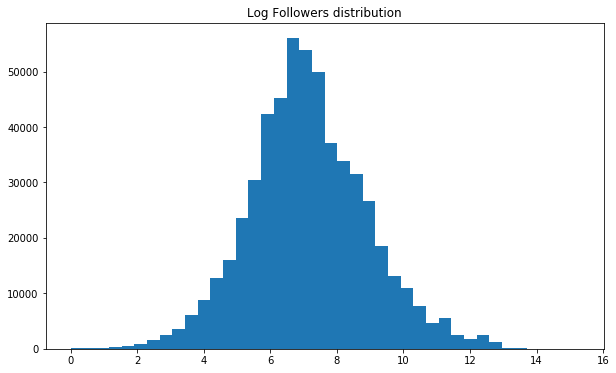

In [21]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt['log_followers'], bins=40)
plt.title('Log Followers distribution')

In [22]:
df_w_rt['log_retweets']=np.log(df_w_rt['retweets'])
df_w_rt['log_retweets']=df_w_rt['log_retweets'].replace(-np.inf, 0)

/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


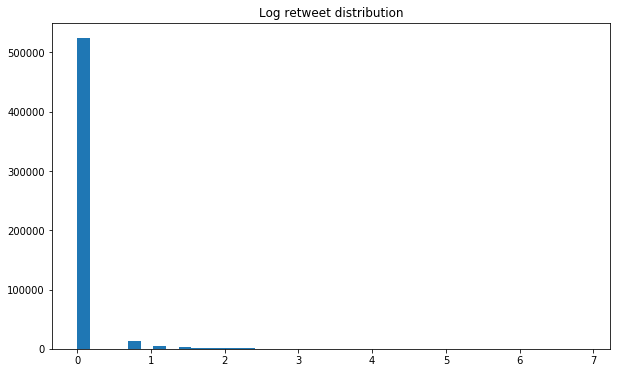

In [23]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt['log_retweets'], bins=40)
plt.title('Log retweet distribution')

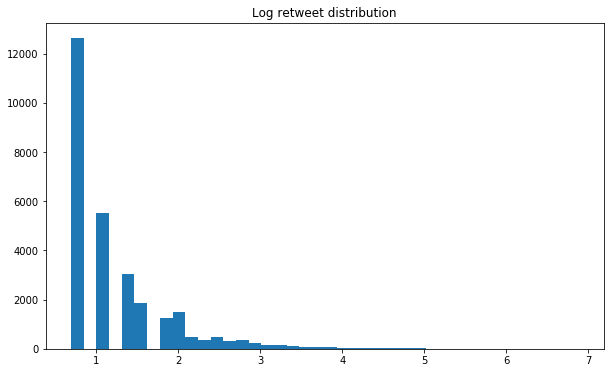

In [24]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt[df_w_rt['log_retweets']>0]['log_retweets'], bins=40)
plt.title('Log retweet distribution')

In [25]:
df_w_rt['engagement_flag']=df_w_rt['retweets']>0
df_w_rt['engagement_flag']=df_w_rt['engagement_flag'].astype(int)

## Tokenizing pared-down dataframe

In [26]:
df_base= df_w_rt[['user.description', 'text', 'topic', 'log_followers', 'log_retweets', 'engagement_flag']]

In [27]:
from gensim import corpora
from gensim.models import Phrases
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import islice
from sklearn.feature_extraction.text import TfidfTransformer

In [28]:
porter_stemmer = PorterStemmer()
tokenizer = TweetTokenizer()
df_base['text_token'] = df_base["text"].apply(tokenizer.tokenize)
df_base['text_token'] = df_base['text_token'].apply(lambda x: [unicode(y.encode("utf-8"), errors='ignore') for y in x])
df_base['text_stemmed'] = df_base["text_token"].apply(lambda x: [porter_stemmer.stem(y) for y in x])

/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [29]:
df_base['text_stemmed']=df_base["text_stemmed"].apply(lambda x: [filter(None, y) for y in x])
df_base['text_processed']=df_base['text_stemmed'].apply(' '.join)

/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
tvec = TfidfVectorizer(min_df=.0001, max_df=.2, stop_words='english', ngram_range=(1,2))
tvec_weights = tvec.fit_transform(df_base['text_processed'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})

In [216]:
positives = ['<U+0082>', '<U+008D>']
outrage = ['<U+00A0>', '<U+00A1>', '<U+00A4>', '<U+00A9>']
df_base['positive_emo']=df_base["text_token"].apply(lambda x: [y in positives for y in x]).apply(lambda x: sum(x))
df_base['outrage_emo']=df_base["text_token"].apply(lambda x: [y in outrage for y in x]).apply(lambda x: sum(x))

/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [220]:
df_base['net_emo_outrage'] = df_base['outrage_emo']-df_base['positive_emo']

/Users/asimonoff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
